In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.utils import resample, compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential  # Corrected import
from tensorflow.keras.layers import (
    Input, Dense, GRU, GlobalAveragePooling1D, Dropout,
    LayerNormalization, MultiHeadAttention, Layer, Bidirectional, Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from transformers import BertTokenizer, TFBertModel

from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

from lime.lime_text import LimeTextExplainer

from spektral.layers import GATConv  # For Graph Attention Networks

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# =====================================
# 1. Imports and Setup
# =====================================

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
# =====================================
# 2. Data Loading and Preprocessing
# =====================================

# Read data
df = pd.read_csv(r"F:\Aspect Based Sentiment Analysis\Resturant\Restaurant - Sheet1.csv")  # Update the path as necessary
df = df[['Text', 'Category', 'Polarity']]

# Initialize Bengali stopwords
stop_words = set(stopwords.words('bengali'))

# Function to clean Bengali text by removing non-Bengali characters, numbers, extra spaces, and stopwords
def clean_text(text):
    if not isinstance(text, str):
        text = ''
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    words = text.split()
    # Remove stopwords without lemmatization
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Function to perform random upsampling
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = [
        resample(
            df[df[target_column] == label],
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        for label in df[target_column].unique()
    ]
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Label Encoding
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])


Category distribution after upsampling:
Category
anecdotes/miscellaneous    2091
ambience                   1929
service                    1506
price                      1394
food                       1308
Name: count, dtype: int64

Polarity distribution after upsampling:
Polarity
positive    2057
neutral     2057
conflict    2057
negative    2057
Name: count, dtype: int64


In [4]:
# =====================================
# 3. Tokenization and Dataset Preparation
# =====================================

# Initialize tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Function to compute sample weights
def compute_sample_weights(df):
    # Compute class weights for Category
    class_weights_category = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['Category_encoded']),
        y=df['Category_encoded']
    )
    class_weights_category = dict(enumerate(class_weights_category))

    # Compute class weights for Polarity
    class_weights_polarity = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['Polarity_encoded']),
        y=df['Polarity_encoded']
    )
    class_weights_polarity = dict(enumerate(class_weights_polarity))

    # Compute sample weights as average of category and polarity weights
    weights_category = df['Category_encoded'].map(class_weights_category)
    weights_polarity = df['Polarity_encoded'].map(class_weights_polarity)
    sample_weights = (weights_category + weights_polarity) / 2
    return sample_weights

# Enhanced create_tensor_dataset function with sample weights
def create_tensor_dataset_with_weights(df, batch_size=16, shuffle=True):
    inputs = tokenizer(
        list(df['Text']), 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)
    sample_weights = tf.convert_to_tensor(compute_sample_weights(df).values)

    # Map labels to their respective output names
    labels = {
        'category_output': labels_category,
        'polarity_output': labels_polarity
    }

    dataset = tf.data.Dataset.from_tensor_slices(
        ((input_ids, attention_mask), labels, sample_weights)
    )
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=42)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets with sample weights
train_dataset = create_tensor_dataset_with_weights(train_df)
val_dataset = create_tensor_dataset_with_weights(val_df, shuffle=False)
test_dataset = create_tensor_dataset_with_weights(test_df, shuffle=False)


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

In [5]:
# =====================================
# 4. Model Definition with Enhancements
# =====================================

# Define Custom GAT Layer using Spektral
class CustomGATLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=4, activation='relu', **kwargs):
        super(CustomGATLayer, self).__init__(**kwargs)
        self.gat = GATConv(channels=units, heads=num_heads, activation=activation)

    def call(self, inputs):
        features, adj = inputs
        return self.gat([features, adj])


# Define Custom Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Adversarial Training Callback
class AdversarialTrainingCallback(Callback):
    def __init__(self, epsilon=1e-3):
        super(AdversarialTrainingCallback, self).__init__()
        self.epsilon = epsilon

    def on_train_batch_begin(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                perturb = self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel)))
                layer.kernel.assign_add(perturb)

    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                layer.kernel.assign_sub(self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel))))

# Define Simple Dense Layer for Direct Pass-Through
class SimplePassThroughLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SimplePassThroughLayer, self).__init__(**kwargs)
        self.dense = Dense(units, activation='relu', name='pass_through_dense')

    def call(self, x):
        return self.dense(x)

# Update the Multi-Task GNN Model to Bypass GRU Fusion
class MultiTaskGNNModelWithoutGRUFusion(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, ff_dim, **kwargs):
        super(MultiTaskGNNModelWithoutGRUFusion, self).__init__(**kwargs)
        self.bert = bert_model
        self.transformer_block = TransformerBlock(embed_dim=gnn_units, num_heads=num_heads, ff_dim=ff_dim, rate=0.1)

        # Bypass Multi-Head Fusion with a simple pass-through layer
        self.pass_through = SimplePassThroughLayer(gnn_units)

        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Shared GNN layers
        self.shared_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Task-specific GNN layers
        self.category_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)
        self.polarity_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Pooling layers
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Output layers
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Feature adjustment
        self.feature_adjustment_layer = Dense(gnn_units, activation='relu')

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        # BERT embeddings
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Feature adjustment
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Additional Transformer Layer
        transformer_output = self.transformer_block(adjusted_features, training=training)

        # Adjacency matrix using Multi-Head Attention
        attention_output = self.multi_head_attention(query=transformer_output, key=transformer_output, value=transformer_output)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # Simple Pass-Through instead of GRU Fusion
        pass_through_features = self.pass_through(transformer_output)

        # Residual connection
        pass_through_features_with_residual = pass_through_features + transformer_output

        # Shared GNN
        shared_features = self.shared_gnn([pass_through_features_with_residual, adj_matrix])

        # Category Task
        category_features = self.category_gnn([shared_features, adj_matrix])
        category_features_with_residual = category_features + shared_features

        # Polarity Task
        polarity_features = self.polarity_gnn([shared_features, adj_matrix])
        polarity_features_with_residual = polarity_features + shared_features

        # Pooling
        category_features_pooled = self.category_pooling(category_features_with_residual)
        polarity_features_pooled = self.polarity_pooling(polarity_features_with_residual)

        # Outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output


# Define Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Model Parameters
gnn_units = 128
category_output_size = len(category_encoder.classes_)  # Dynamically set based on data
polarity_output_size = len(polarity_encoder.classes_)  # Dynamically set based on data
num_heads = 4
ff_dim = 256  # Feed-forward network dimension for Transformer

# Instantiate Model
multi_task_gnn_model = MultiTaskGNNModelWithoutGRUFusion(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size,
    ff_dim=ff_dim
)

# Build Model
output_category, output_polarity = multi_task_gnn_model((input_ids, attention_mask))

# Explicitly name the outputs to match the loss and metrics dictionaries
output_category = tf.keras.layers.Lambda(lambda x: x, name='category_output')(output_category)
output_polarity = tf.keras.layers.Lambda(lambda x: x, name='polarity_output')(output_polarity)

model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Display Model Summary
model.summary()

f:\Mini Conda\envs\env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_without_g  ((None, 5),         178481673   ['input_ids[0][0]',              
 ru_fusion (MultiTaskGNNModelWi   (None, 4))                      'attention_mask[0][0]']         
 thoutGRUFusion)                                                                                  
                                                                                              

In [6]:
# =====================================
# 5. Compilation and Callbacks
# =====================================

# Define Learning Rate Schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the Model with unique metric names
model.compile(
    optimizer=Adam(
    learning_rate=1e-5,
    clipvalue=1.0
),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'category_output': ['accuracy'],
        'polarity_output': ['accuracy']
    }
)

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-7
)

adversarial_callback = AdversarialTrainingCallback(epsilon=1e-3)


In [7]:
# =====================================
# 6. Training
# =====================================

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr, adversarial_callback]
)


Epoch 1/5
371/371 [==============================] - ETA: 0s - loss: 2.4763 - category_output_loss: 1.2963 - polarity_output_loss: 1.1800 - category_output_accuracy: 0.5232 - polarity_output_accuracy: 0.4984WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_loss improved from inf to 1.73298, saving model to best_model.h5
371/371 [==============================] - 220s 543ms/step - loss: 2.4763 - category_output_loss: 1.2963 - polarity_output_loss: 1.1800 - category_output_accuracy: 0.5232 - polarity_output_accuracy: 0.4984 - val_loss: 1.7330 - val_category_output_loss: 0.8855 - val_polarity_output_loss: 0.8475 - val_category_output_accuracy: 0.7739 - val_polarity_output_accuracy: 0.7572 - lr: 1.0000e-05
Epoch 2/5
371/371 [=================

In [8]:
# =====================================
# 7. Evaluation
# =====================================

# Evaluate the model on the test dataset
test_metrics = model.evaluate(test_dataset)
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")

103/103 [==============================] - 12s 118ms/step - loss: 0.5105 - category_output_loss: 0.3526 - polarity_output_loss: 0.1579 - category_output_accuracy: 0.8906 - polarity_output_accuracy: 0.9599
Test Category Loss: 0.3525792062282562, Test Category Accuracy: 0.8906440138816833
Test Polarity Loss: 0.1579064279794693, Test Polarity Accuracy: 0.959902822971344


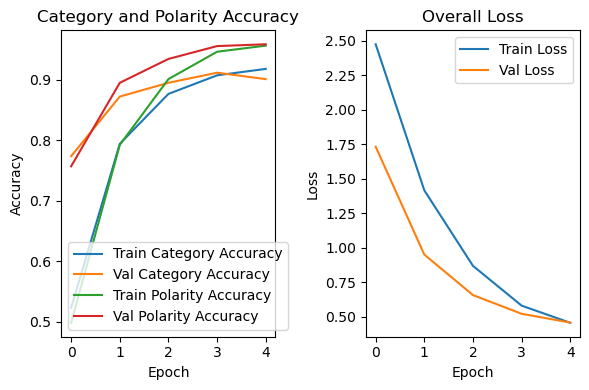

In [9]:
# =====================================
# 8. Visualization of Training Metrics
# =====================================

# Plot training & validation accuracy for Category and Polarity
plt.figure(figsize=(6, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Train Category Accuracy')
plt.plot(history.history['val_category_output_accuracy'], label='Val Category Accuracy')
plt.plot(history.history['polarity_output_accuracy'], label='Train Polarity Accuracy')
plt.plot(history.history['val_polarity_output_accuracy'], label='Val Polarity Accuracy')
plt.title('Category and Polarity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

# Take a few samples from the test dataset for predictions
for (input_ids, attention_mask), labels_dict, _ in test_dataset.take(5):
    # Get the true labels from labels_dict
    category_labels = labels_dict['category_output']
    polarity_labels = labels_dict['polarity_output']

    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])

    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)

    # Convert the true labels to numpy arrays
    true_category_labels = category_labels.numpy()
    true_polarity_labels = polarity_labels.numpy()

    # Append the true and predicted labels to the lists
    y_true_category.extend(true_category_labels.tolist())
    y_true_polarity.extend(true_polarity_labels.tolist())
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())

    # Display results
    for i in range(len(true_category_labels)):
        true_cat_label = category_encoder.inverse_transform([true_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([true_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]

        print(f"Sample {i+1}:")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()


# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


1/1 [==============================] - 3s 3s/step
Sample 1:
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  True Category: food
  Predicted Category: food
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 5:
  True Category: anecdotes/miscellaneous
  Predicted Category: anecdotes/miscellaneous
  True Polarity: positive
  Predicted Polarity: positive

Sample 6:
  True Category: service
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 7:
  True Category: food
  Predicted Category: food
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 8:
  True Category: food
  Predicted Category: food
  True Polarity: n

In [11]:
import math

batch_size = 16  # You can adjust the batch size as needed

# Ensure test_df indices are reset
test_df = test_df.reset_index(drop=True)

# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

num_samples = len(test_df)
num_batches = math.ceil(num_samples / batch_size)

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, num_samples)
    
    # Extract batch data
    batch_texts = test_df['Text'].iloc[start_idx:end_idx].tolist()
    batch_category_labels = test_df['Category_encoded'].iloc[start_idx:end_idx].tolist()
    batch_polarity_labels = test_df['Polarity_encoded'].iloc[start_idx:end_idx].tolist()
    
    # Tokenize batch texts
    inputs = tokenizer(
        batch_texts, 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask], verbose=0)
    
    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)
    
    # Append true labels and predictions
    y_true_category.extend(batch_category_labels)
    y_true_polarity.extend(batch_polarity_labels)
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())
    
    # Display results for each sample in the batch
    for i in range(len(batch_texts)):
        true_cat_label = category_encoder.inverse_transform([batch_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([batch_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]
        text = batch_texts[i]
        
        print(f"Sample {start_idx + i + 1}:")
        print(f"  Text: {text}")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()

# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category, target_names=category_encoder.classes_))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity, target_names=polarity_encoder.classes_))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


Sample 1:
  Text: এছাড়াও নিশ্চিত সঙ্গীতের মনোযোগ দিচ্ছেন অদ্ভুত নির্বাচন
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  Text: সমস্যা যেহেতু টাকায় ডিশের দিয়েছি সুস্বাদু স্বাদ পেতে খাবারের অর্ডার
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  Text: টেবিলের পাশাপাশি রেস্তোরাঁর প্রতিদ্বন্দ্বীদের দুইবার প্রতিশ্রুতি দিয়েছিলাম আসলেই তিনবার অর্ডার তিনটি অর্ডার বাকিটা টেবিলের বাকি বসার মিনিট অর্ডারগুলির পেয়েছি আদেশটি পুরাপুরি বিলিয়ন ডলারের চার্জ করেছি বিলের
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  Text: বৃহদাকার সামুদ্রিক মাছ মসলাযুক্ত মজর একজন বড় ভোজক ছিলাম শুধুমাত্র অর্ধেক খেতে পারছি প্রেমিক অতুলনীয় মাছ চিপস বড় পরিবেশন টুকরা মাছ ভাজাপরিবেশন করত
  True Category: food
  Predicted Category: food
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 

In [5]:
# ================================
# Modified Multi-Task Model Without GNN
# ================================

# Define Custom Transformer Block (remains the same)
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Simple Dense Layer for Direct Pass-Through
class SimplePassThroughLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SimplePassThroughLayer, self).__init__(**kwargs)
        self.dense = Dense(units, activation='relu', name='pass_through_dense')

    def call(self, x):
        return self.dense(x)

# Update the Multi-Task Model
class MultiTaskModelWithoutGNN(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, ff_dim, **kwargs):
        super(MultiTaskModelWithoutGNN, self).__init__(**kwargs)
        self.bert = bert_model
        self.transformer_block = TransformerBlock(embed_dim=gnn_units, num_heads=num_heads, ff_dim=ff_dim, rate=0.1)
        
        # Pass-through layer (bypasses GNN)
        self.pass_through = SimplePassThroughLayer(gnn_units)

        # Pooling layers
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Output layers
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Feature adjustment layer
        self.feature_adjustment_layer = Dense(gnn_units, activation='relu')

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        # BERT embeddings
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Feature adjustment
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Additional Transformer Layer
        transformer_output = self.transformer_block(adjusted_features, training=training)

        # Simple Pass-Through (instead of GNN)
        pass_through_features = self.pass_through(transformer_output)

        # Pooling
        category_features_pooled = self.category_pooling(pass_through_features)
        polarity_features_pooled = self.polarity_pooling(pass_through_features)

        # Outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

# Define Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Model Parameters
gnn_units = 128
category_output_size = len(category_encoder.classes_)  # Dynamically set based on data
polarity_output_size = len(polarity_encoder.classes_)  # Dynamically set based on data
num_heads = 4
ff_dim = 256  # Feed-forward network dimension for Transformer

# Instantiate Model
multi_task_model = MultiTaskModelWithoutGNN(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size,
    ff_dim=ff_dim
)

# Build Model
output_category, output_polarity = multi_task_model((input_ids, attention_mask))

# Explicitly name the outputs to match the loss and metrics dictionaries
output_category = tf.keras.layers.Lambda(lambda x: x, name='category_output')(output_category)
output_polarity = tf.keras.layers.Lambda(lambda x: x, name='polarity_output')(output_polarity)

model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Display Model Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_model_without_gnn (  ((None, 5),         178299785   ['input_ids[0][0]',              
 MultiTaskModelWithoutGNN)       (None, 4))                       'attention_mask[0][0]']         
                                                                                                  
 category_output (Lambda)       (None, 5)            0           ['multi_task_model_without_gn

In [6]:
# Compile the Model with unique metric names
model.compile(
    optimizer=Adam(
    learning_rate=1e-5,
    clipvalue=1.0
),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'category_output': ['accuracy'],
        'polarity_output': ['accuracy']
    }
)

In [7]:
# =====================================
# 6. Training
# =====================================

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
)


Epoch 1/5
371/371 [==============================] - 198s 479ms/step - loss: 1.9741 - category_output_loss: 1.0315 - polarity_output_loss: 0.9427 - category_output_accuracy: 0.6097 - polarity_output_accuracy: 0.6139 - val_loss: 0.9838 - val_category_output_loss: 0.5468 - val_polarity_output_loss: 0.4369 - val_category_output_accuracy: 0.8346 - val_polarity_output_accuracy: 0.8528
Epoch 2/5
371/371 [==============================] - 178s 480ms/step - loss: 0.8664 - category_output_loss: 0.4827 - polarity_output_loss: 0.3837 - category_output_accuracy: 0.8428 - polarity_output_accuracy: 0.8783 - val_loss: 0.5662 - val_category_output_loss: 0.3269 - val_polarity_output_loss: 0.2393 - val_category_output_accuracy: 0.9029 - val_polarity_output_accuracy: 0.9393
Epoch 3/5
371/371 [==============================] - 175s 472ms/step - loss: 0.5634 - category_output_loss: 0.3363 - polarity_output_loss: 0.2271 - category_output_accuracy: 0.8997 - polarity_output_accuracy: 0.9392 - val_loss: 0.4847

In [8]:
# =====================================
# 7. Evaluation
# =====================================

# Evaluate the model on the test dataset
test_metrics = model.evaluate(test_dataset)
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")

103/103 [==============================] - 12s 115ms/step - loss: 0.4580 - category_output_loss: 0.3159 - polarity_output_loss: 0.1421 - category_output_accuracy: 0.8894 - polarity_output_accuracy: 0.9623
Test Category Loss: 0.3158821761608124, Test Category Accuracy: 0.8894289135932922
Test Polarity Loss: 0.14213067293167114, Test Polarity Accuracy: 0.9623329043388367


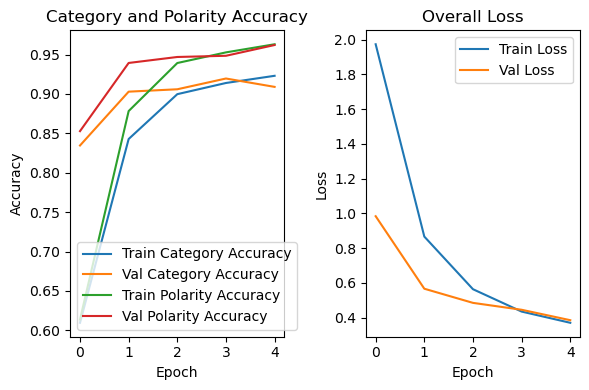

In [9]:
# =====================================
# 8. Visualization of Training Metrics
# =====================================

# Plot training & validation accuracy for Category and Polarity
plt.figure(figsize=(6, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Train Category Accuracy')
plt.plot(history.history['val_category_output_accuracy'], label='Val Category Accuracy')
plt.plot(history.history['polarity_output_accuracy'], label='Train Polarity Accuracy')
plt.plot(history.history['val_polarity_output_accuracy'], label='Val Polarity Accuracy')
plt.title('Category and Polarity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

# Take a few samples from the test dataset for predictions
for (input_ids, attention_mask), labels_dict, _ in test_dataset.take(5):
    # Get the true labels from labels_dict
    category_labels = labels_dict['category_output']
    polarity_labels = labels_dict['polarity_output']

    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])

    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)

    # Convert the true labels to numpy arrays
    true_category_labels = category_labels.numpy()
    true_polarity_labels = polarity_labels.numpy()

    # Append the true and predicted labels to the lists
    y_true_category.extend(true_category_labels.tolist())
    y_true_polarity.extend(true_polarity_labels.tolist())
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())

    # Display results
    for i in range(len(true_category_labels)):
        true_cat_label = category_encoder.inverse_transform([true_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([true_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]

        print(f"Sample {i+1}:")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()


# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


1/1 [==============================] - 4s 4s/step
Sample 1:
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  True Category: food
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 5:
  True Category: anecdotes/miscellaneous
  Predicted Category: anecdotes/miscellaneous
  True Polarity: positive
  Predicted Polarity: positive

Sample 6:
  True Category: service
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 7:
  True Category: food
  Predicted Category: food
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 8:
  True Category: food
  Predicted Category: food
  True Polarity

In [11]:
import math

batch_size = 16  # You can adjust the batch size as needed

# Ensure test_df indices are reset
test_df = test_df.reset_index(drop=True)

# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

num_samples = len(test_df)
num_batches = math.ceil(num_samples / batch_size)

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, num_samples)
    
    # Extract batch data
    batch_texts = test_df['Text'].iloc[start_idx:end_idx].tolist()
    batch_category_labels = test_df['Category_encoded'].iloc[start_idx:end_idx].tolist()
    batch_polarity_labels = test_df['Polarity_encoded'].iloc[start_idx:end_idx].tolist()
    
    # Tokenize batch texts
    inputs = tokenizer(
        batch_texts, 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask], verbose=0)
    
    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)
    
    # Append true labels and predictions
    y_true_category.extend(batch_category_labels)
    y_true_polarity.extend(batch_polarity_labels)
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())
    
    # Display results for each sample in the batch
    for i in range(len(batch_texts)):
        true_cat_label = category_encoder.inverse_transform([batch_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([batch_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]
        text = batch_texts[i]
        
        print(f"Sample {start_idx + i + 1}:")
        print(f"  Text: {text}")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()

# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category, target_names=category_encoder.classes_))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity, target_names=polarity_encoder.classes_))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


Sample 1:
  Text: এছাড়াও নিশ্চিত সঙ্গীতের মনোযোগ দিচ্ছেন অদ্ভুত নির্বাচন
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  Text: সমস্যা যেহেতু টাকায় ডিশের দিয়েছি সুস্বাদু স্বাদ পেতে খাবারের অর্ডার
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  Text: টেবিলের পাশাপাশি রেস্তোরাঁর প্রতিদ্বন্দ্বীদের দুইবার প্রতিশ্রুতি দিয়েছিলাম আসলেই তিনবার অর্ডার তিনটি অর্ডার বাকিটা টেবিলের বাকি বসার মিনিট অর্ডারগুলির পেয়েছি আদেশটি পুরাপুরি বিলিয়ন ডলারের চার্জ করেছি বিলের
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  Text: বৃহদাকার সামুদ্রিক মাছ মসলাযুক্ত মজর একজন বড় ভোজক ছিলাম শুধুমাত্র অর্ধেক খেতে পারছি প্রেমিক অতুলনীয় মাছ চিপস বড় পরিবেশন টুকরা মাছ ভাজাপরিবেশন করত
  True Category: food
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: conflict

Samp

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dense, GRU, LayerNormalization, Dropout, 
    MultiHeadAttention, GlobalAveragePooling1D, Lambda, Layer
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback
from spektral.layers import GATConv

# =====================================
# 4. Model Definition with Enhancements
# =====================================

# Define Custom GAT Layer using Spektral
class CustomGATLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=4, activation='relu', **kwargs):
        super(CustomGATLayer, self).__init__(**kwargs)
        self.gat = GATConv(channels=units, heads=num_heads, activation=activation)

    def call(self, inputs):
        features, adj = inputs
        return self.gat([features, adj])

# Define Multi-Head Fusion Layer
class MultiHeadFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=4, **kwargs):
        super(MultiHeadFusionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.gru_layers = [GRU(units, return_sequences=True, name=f'gru_{i}') for i in range(num_heads)]
        self.concat = Dense(units, activation='relu', name='fusion_concat')

    def call(self, x):
        fused = [gru(x) for gru in self.gru_layers]
        fused = tf.concat(fused, axis=-1)
        return self.concat(fused)

# Define Custom Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection
        ffn_output = self.ffn(out1)  # Feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Second residual connection

# Define Adversarial Training Callback
class AdversarialTrainingCallback(Callback):
    def __init__(self, epsilon=1e-3):
        super(AdversarialTrainingCallback, self).__init__()
        self.epsilon = epsilon

    def on_train_batch_begin(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                perturb = self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel)))
                layer.kernel.assign_add(perturb)

    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                layer.kernel.assign_sub(self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel))))

# Define Multi-Task GNN Model with Enhancements
class MultiTaskGNNModel(Model):
    def __init__(self, vocab_size, gnn_units, category_output_size, polarity_output_size, num_heads, ff_dim, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        
        # Embedding Layer
        self.embedding = Embedding(
            input_dim=vocab_size, 
            output_dim=gnn_units, 
            input_length=128, 
            name='embedding_layer'
        )
        
        # Feature adjustment
        self.feature_adjustment_layer = Dense(gnn_units, activation='relu')

        # Additional Transformer Layer
        self.transformer_block = TransformerBlock(embed_dim=gnn_units, num_heads=num_heads, ff_dim=ff_dim, rate=0.1)
        
        # Multi-Head Fusion
        self.multi_head_fusion = MultiHeadFusionLayer(gnn_units, num_heads=num_heads)

        # Multi-Head Attention for Adjacency Matrix
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=gnn_units)

        # Shared GNN layers
        self.shared_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Task-specific GNN layers
        self.category_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)
        self.polarity_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Pooling layers
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Output layers
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs  # attention_mask is unused in this setup

        # Embedding
        embedded = self.embedding(input_ids)  # Shape: (batch_size, 128, gnn_units)

        # Feature adjustment
        adjusted_features = self.feature_adjustment_layer(embedded)  # Shape: (batch_size, 128, gnn_units)

        # Additional Transformer Layer
        transformer_output = self.transformer_block(adjusted_features, training=training)  # Shape: (batch_size, 128, gnn_units)

        # Adjacency matrix using Multi-Head Attention
        attention_output = self.multi_head_attention(query=transformer_output, key=transformer_output, value=transformer_output)  # Shape: (batch_size, 128, gnn_units)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)  # Shape: (batch_size, 128, gnn_units)

        # Multi-Head Fusion
        fused_features = self.multi_head_fusion(transformer_output)  # Shape: (batch_size, 128, gnn_units)

        # Residual connection
        fused_features_with_residual = fused_features + transformer_output  # Shape: (batch_size, 128, gnn_units)

        # Shared GNN
        shared_features = self.shared_gnn([fused_features_with_residual, adj_matrix])  # Shape: (batch_size, 128, gnn_units)

        # Category Task
        category_features = self.category_gnn([shared_features, adj_matrix])  # Shape: (batch_size, 128, gnn_units)
        category_features_with_residual = category_features + shared_features  # Shape: (batch_size, 128, gnn_units)

        # Polarity Task
        polarity_features = self.polarity_gnn([shared_features, adj_matrix])  # Shape: (batch_size, 128, gnn_units)
        polarity_features_with_residual = polarity_features + shared_features  # Shape: (batch_size, 128, gnn_units)

        # Pooling
        category_features_pooled = self.category_pooling(category_features_with_residual)  # Shape: (batch_size, gnn_units)
        polarity_features_pooled = self.polarity_pooling(polarity_features_with_residual)  # Shape: (batch_size, gnn_units)

        # Outputs
        category_output = self.category_output_layer(category_features_pooled)  # Shape: (batch_size, category_output_size)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)  # Shape: (batch_size, polarity_output_size)

        return category_output, polarity_output

# Define Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')  # Unused but kept for consistency

# Model Parameters
vocab_size = 30522  # Example vocab size for BERT; adjust based on your dataset
gnn_units = 128
category_output_size = len(category_encoder.classes_)  # Dynamically set based on data
polarity_output_size = len(polarity_encoder.classes_)  # Dynamically set based on data
num_heads = 4
ff_dim = 256  # Feed-forward network dimension for Transformer

# Instantiate Model
multi_task_gnn_model = MultiTaskGNNModel(
    vocab_size=vocab_size,
    gnn_units=gnn_units,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size,
    num_heads=num_heads,
    ff_dim=ff_dim
)

# Build Model by passing inputs through the model
output_category, output_polarity = multi_task_gnn_model((input_ids, attention_mask))

# Explicitly name the outputs to match the loss and metrics dictionaries
output_category = Lambda(lambda x: x, name='category_output')(output_category)
output_polarity = Lambda(lambda x: x, name='polarity_output')(output_polarity)

# Define the complete model
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Display Model Summary
model.summary()


f:\Mini Conda\envs\env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model (MultiTas  ((None, 5),         5030409     ['input_ids[0][0]',              
 kGNNModel)                      (None, 4))                       'attention_mask[0][0]']         
                                                                                                  
 category_output (Lambda)       (None, 5)            0           ['multi_task_gnn_model[0][0

In [13]:
# =====================================
# 5. Compilation and Callbacks
# =====================================

# Define Learning Rate Schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the Model with unique metric names
model.compile(
    optimizer=Adam(
    learning_rate=1e-5,
    clipvalue=1.0
),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'category_output': ['accuracy'],
        'polarity_output': ['accuracy']
    }
)

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-7
)

adversarial_callback = AdversarialTrainingCallback(epsilon=1e-3)


In [14]:
# =====================================
# 6. Training
# =====================================

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr, adversarial_callback]
)


Epoch 1/50
371/371 [==============================] - ETA: 0s - loss: 2.9833 - category_output_loss: 1.5997 - polarity_output_loss: 1.3836 - category_output_accuracy: 0.2630 - polarity_output_accuracy: 0.2646WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_loss improved from inf to 2.96554, saving model to best_model.h5
371/371 [==============================] - 42s 71ms/step - loss: 2.9833 - category_output_loss: 1.5997 - polarity_output_loss: 1.3836 - category_output_accuracy: 0.2630 - polarity_output_accuracy: 0.2646 - val_loss: 2.9655 - val_category_output_loss: 1.5860 - val_polarity_output_loss: 1.3795 - val_category_output_accuracy: 0.2838 - val_polarity_output_accuracy: 0.2671 - lr: 1.0000e-05
Epoch 2/50
371/371 [=================

In [15]:
# =====================================
# 7. Evaluation
# =====================================

# Evaluate the model on the test dataset
test_metrics = model.evaluate(test_dataset)
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")

103/103 [==============================] - 3s 27ms/step - loss: 1.9999 - category_output_loss: 1.1548 - polarity_output_loss: 0.8452 - category_output_accuracy: 0.5680 - polarity_output_accuracy: 0.6561
Test Category Loss: 1.1547693014144897, Test Category Accuracy: 0.5680437684059143
Test Polarity Loss: 0.84517902135849, Test Polarity Accuracy: 0.6561360955238342


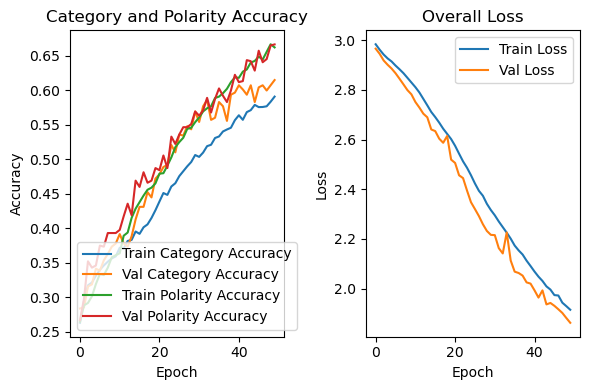

In [16]:
# =====================================
# 8. Visualization of Training Metrics
# =====================================

# Plot training & validation accuracy for Category and Polarity
plt.figure(figsize=(6, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Train Category Accuracy')
plt.plot(history.history['val_category_output_accuracy'], label='Val Category Accuracy')
plt.plot(history.history['polarity_output_accuracy'], label='Train Polarity Accuracy')
plt.plot(history.history['val_polarity_output_accuracy'], label='Val Polarity Accuracy')
plt.title('Category and Polarity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

# Take a few samples from the test dataset for predictions
for (input_ids, attention_mask), labels_dict, _ in test_dataset.take(5):
    # Get the true labels from labels_dict
    category_labels = labels_dict['category_output']
    polarity_labels = labels_dict['polarity_output']

    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])

    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)

    # Convert the true labels to numpy arrays
    true_category_labels = category_labels.numpy()
    true_polarity_labels = polarity_labels.numpy()

    # Append the true and predicted labels to the lists
    y_true_category.extend(true_category_labels.tolist())
    y_true_polarity.extend(true_polarity_labels.tolist())
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())

    # Display results
    for i in range(len(true_category_labels)):
        true_cat_label = category_encoder.inverse_transform([true_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([true_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]

        print(f"Sample {i+1}:")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()


# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


1/1 [==============================] - 1s 1s/step
Sample 1:
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  True Category: price
  Predicted Category: service
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  True Category: food
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: negative

Sample 5:
  True Category: anecdotes/miscellaneous
  Predicted Category: price
  True Polarity: positive
  Predicted Polarity: negative

Sample 6:
  True Category: service
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 7:
  True Category: food
  Predicted Category: ambience
  True Polarity: conflict
  Predicted Polarity: conflict

Sample 8:
  True Category: food
  Predicted Category: price
  True Polarity: negative


In [18]:
import math

batch_size = 16  # You can adjust the batch size as needed

# Ensure test_df indices are reset
test_df = test_df.reset_index(drop=True)

# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

num_samples = len(test_df)
num_batches = math.ceil(num_samples / batch_size)

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, num_samples)
    
    # Extract batch data
    batch_texts = test_df['Text'].iloc[start_idx:end_idx].tolist()
    batch_category_labels = test_df['Category_encoded'].iloc[start_idx:end_idx].tolist()
    batch_polarity_labels = test_df['Polarity_encoded'].iloc[start_idx:end_idx].tolist()
    
    # Tokenize batch texts
    inputs = tokenizer(
        batch_texts, 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask], verbose=0)
    
    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)
    
    # Append true labels and predictions
    y_true_category.extend(batch_category_labels)
    y_true_polarity.extend(batch_polarity_labels)
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())
    
    # Display results for each sample in the batch
    for i in range(len(batch_texts)):
        true_cat_label = category_encoder.inverse_transform([batch_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([batch_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]
        text = batch_texts[i]
        
        print(f"Sample {start_idx + i + 1}:")
        print(f"  Text: {text}")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()

# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category, target_names=category_encoder.classes_))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity, target_names=polarity_encoder.classes_))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


Sample 1:
  Text: এছাড়াও নিশ্চিত সঙ্গীতের মনোযোগ দিচ্ছেন অদ্ভুত নির্বাচন
  True Category: ambience
  Predicted Category: ambience
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 2:
  Text: সমস্যা যেহেতু টাকায় ডিশের দিয়েছি সুস্বাদু স্বাদ পেতে খাবারের অর্ডার
  True Category: price
  Predicted Category: price
  True Polarity: negative
  Predicted Polarity: negative

Sample 3:
  Text: টেবিলের পাশাপাশি রেস্তোরাঁর প্রতিদ্বন্দ্বীদের দুইবার প্রতিশ্রুতি দিয়েছিলাম আসলেই তিনবার অর্ডার তিনটি অর্ডার বাকিটা টেবিলের বাকি বসার মিনিট অর্ডারগুলির পেয়েছি আদেশটি পুরাপুরি বিলিয়ন ডলারের চার্জ করেছি বিলের
  True Category: price
  Predicted Category: service
  True Polarity: negative
  Predicted Polarity: negative

Sample 4:
  Text: বৃহদাকার সামুদ্রিক মাছ মসলাযুক্ত মজর একজন বড় ভোজক ছিলাম শুধুমাত্র অর্ধেক খেতে পারছি প্রেমিক অতুলনীয় মাছ চিপস বড় পরিবেশন টুকরা মাছ ভাজাপরিবেশন করত
  True Category: food
  Predicted Category: service
  True Polarity: conflict
  Predicted Polarity: negative

Sa

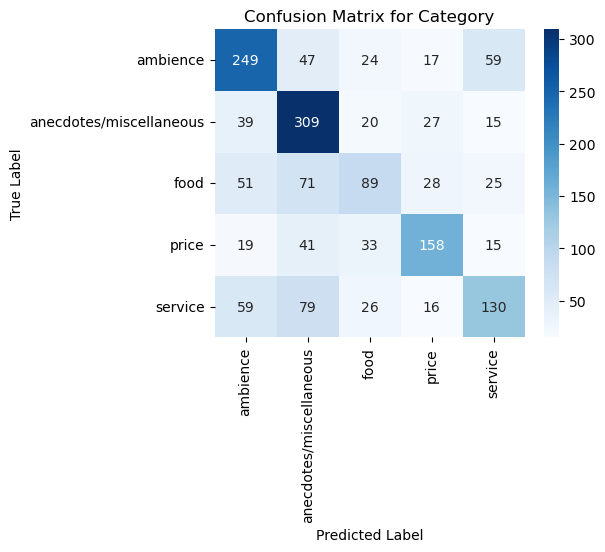

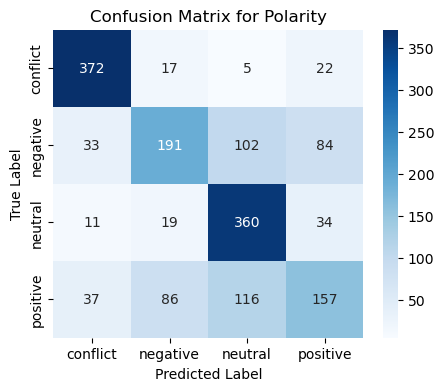

Misclassified Samples for Category:
                                                 Text  \
2   টেবিলের পাশাপাশি রেস্তোরাঁর প্রতিদ্বন্দ্বীদের ...   
3   বৃহদাকার সামুদ্রিক মাছ মসলাযুক্ত মজর একজন বড় ...   
4                                             অতুলনীয়   
6   খানে খাবার সভাগুলি মহান নাআমাদের লেবুর সালাদ ম...   
7                             টম খা স্যুপটি অনুপযুক্ত   
10  তে ভাল রেস্টুরেন্ট অত্যধিক খাদ্যের প্রয়োজন অপ...   
15  বছরের ঘুরে স্ত্রী যাচ্ছি রকসির খাদ্য মিস চাইনা...   
16                         টাটকা উপাদান সবকিছু অর্ডার   
19      দয়া সম্পর্কে চিন্তা করুন অপেক্ষায় থাকুন হতাশ   
20  গড় আমেরিকান পাচনতন্ত্রের সাথে ভালভাবে জাল খার...   

              True_Category Predicted_Category  
2                     price            service  
3                      food            service  
4   anecdotes/miscellaneous              price  
6                      food           ambience  
7                      food              price  
10                     food            ser

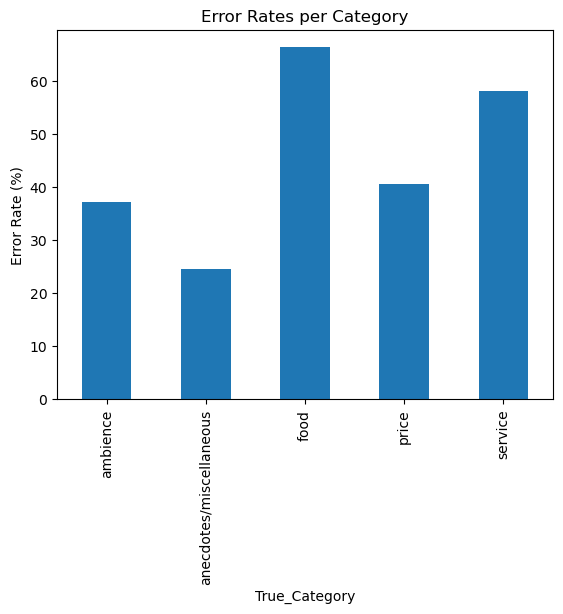

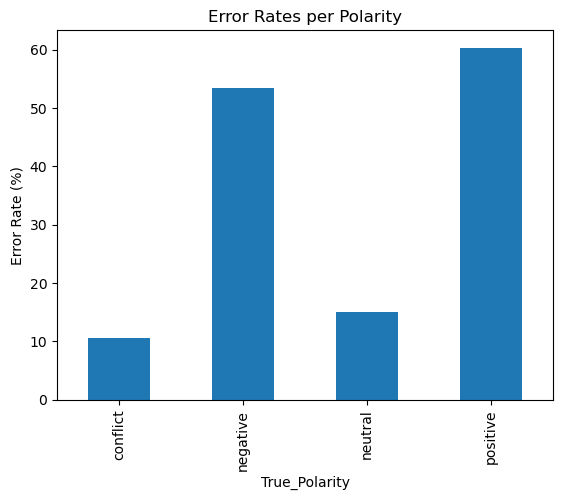

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a DataFrame with texts, true labels, and predicted labels
results_df = test_df.copy()
results_df['True_Category'] = category_encoder.inverse_transform(y_true_category)
results_df['Predicted_Category'] = category_encoder.inverse_transform(y_pred_category)
results_df['True_Polarity'] = polarity_encoder.inverse_transform(y_true_polarity)
results_df['Predicted_Polarity'] = polarity_encoder.inverse_transform(y_pred_polarity)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# Plot confusion matrix for Category
plot_confusion_matrix(
    y_true_category, y_pred_category, 
    classes=category_encoder.classes_, 
    title='Confusion Matrix for Category'
)

# Plot confusion matrix for Polarity
plot_confusion_matrix(
    y_true_polarity, y_pred_polarity, 
    classes=polarity_encoder.classes_, 
    title='Confusion Matrix for Polarity'
)

# Identify misclassified samples for Category
misclassified_category = results_df[results_df['True_Category'] != results_df['Predicted_Category']]

# Identify misclassified samples for Polarity
misclassified_polarity = results_df[results_df['True_Polarity'] != results_df['Predicted_Polarity']]

# Display some misclassified samples for Category
print("Misclassified Samples for Category:")
print(misclassified_category[['Text', 'True_Category', 'Predicted_Category']].head(10))

# Display some misclassified samples for Polarity
print("\nMisclassified Samples for Polarity:")
print(misclassified_polarity[['Text', 'True_Polarity', 'Predicted_Polarity']].head(10))

# Calculate error rates per class for Category
category_errors = misclassified_category.groupby('True_Category').size()
category_totals = results_df.groupby('True_Category').size()
category_error_rates = (category_errors / category_totals) * 100

print("\nCategory Error Rates (%):")
print(category_error_rates)

# Calculate error rates per class for Polarity
polarity_errors = misclassified_polarity.groupby('True_Polarity').size()
polarity_totals = results_df.groupby('True_Polarity').size()
polarity_error_rates = (polarity_errors / polarity_totals) * 100

print("\nPolarity Error Rates (%):")
print(polarity_error_rates)

# Bar plot of error rates for Category
category_error_rates.plot(kind='bar', title='Error Rates per Category')
plt.ylabel('Error Rate (%)')
plt.show()

# Bar plot of error rates for Polarity
polarity_error_rates.plot(kind='bar', title='Error Rates per Polarity')
plt.ylabel('Error Rate (%)')
plt.show()
